# Load Data


Pastikan dataset berada pada `data/raw`


In [1]:
import os
import cv2
from tqdm import tqdm
from util import read_images
from preprocessing import preprocess_image
%load_ext autoreload
%autoreload 2

folders =[]
# iterate over all folder in raw
raw_path = "data/raw"
for data_type_folder in os.listdir(raw_path):
    for skin_cancer_type_folder in os.listdir(os.path.join(raw_path, data_type_folder)):
          folders.append(os.path.join( data_type_folder, skin_cancer_type_folder))

# Pembersihan Citra & Segmentasi Citra


In [2]:
for folder in folders:
  raw_path_folder = os.path.join(raw_path, folder)
  preprocessed_path_folder = os.path.join("data/preprocessed", folder)
  
  images = read_images(raw_path_folder)
  for i, (image_array, label) in enumerate(tqdm(images)):
      preprocessed_image = preprocess_image(image_array)
      

      # Save the image
      image_path = os.path.join(preprocessed_path_folder, f"{label}")
      cv2.imwrite(image_path, preprocessed_image)

100%|██████████| 1197/1197 [00:08<00:00, 147.89it/s]


## Beberapa gambar yang dibersihkan


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


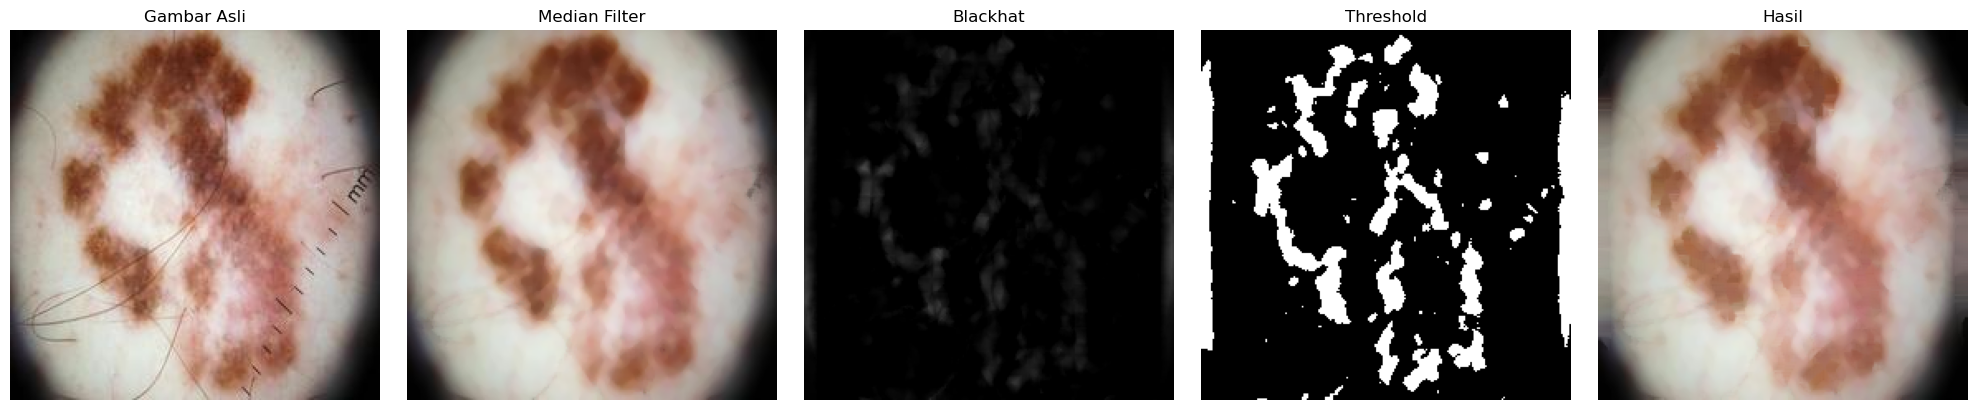

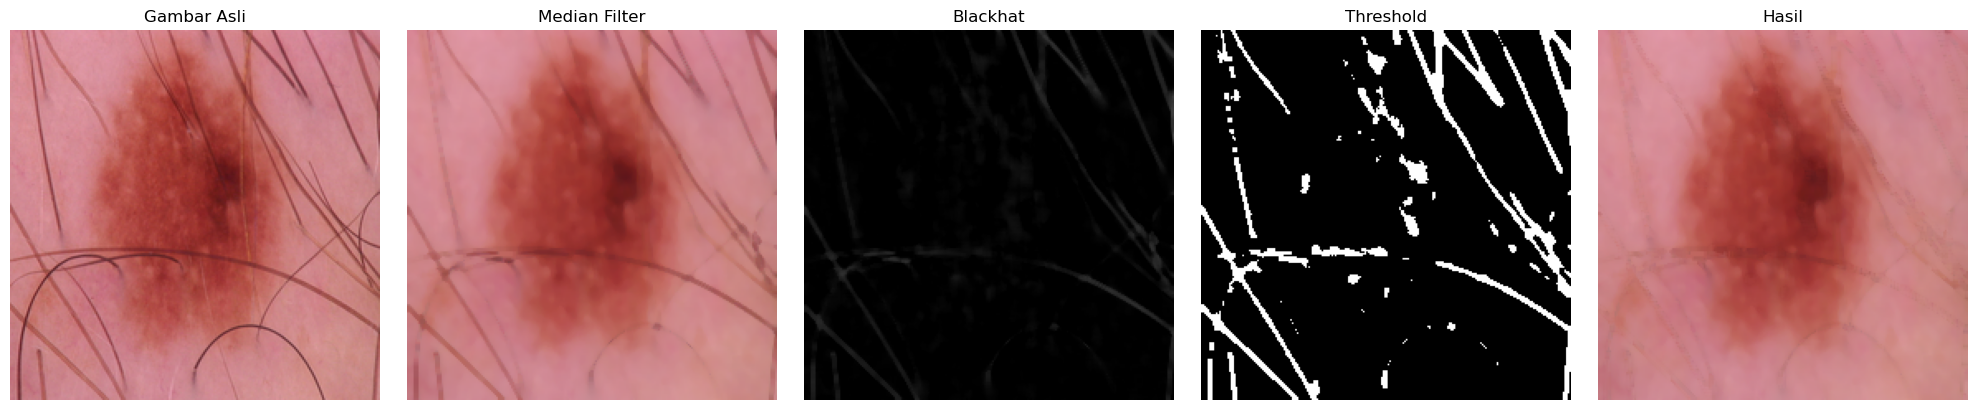

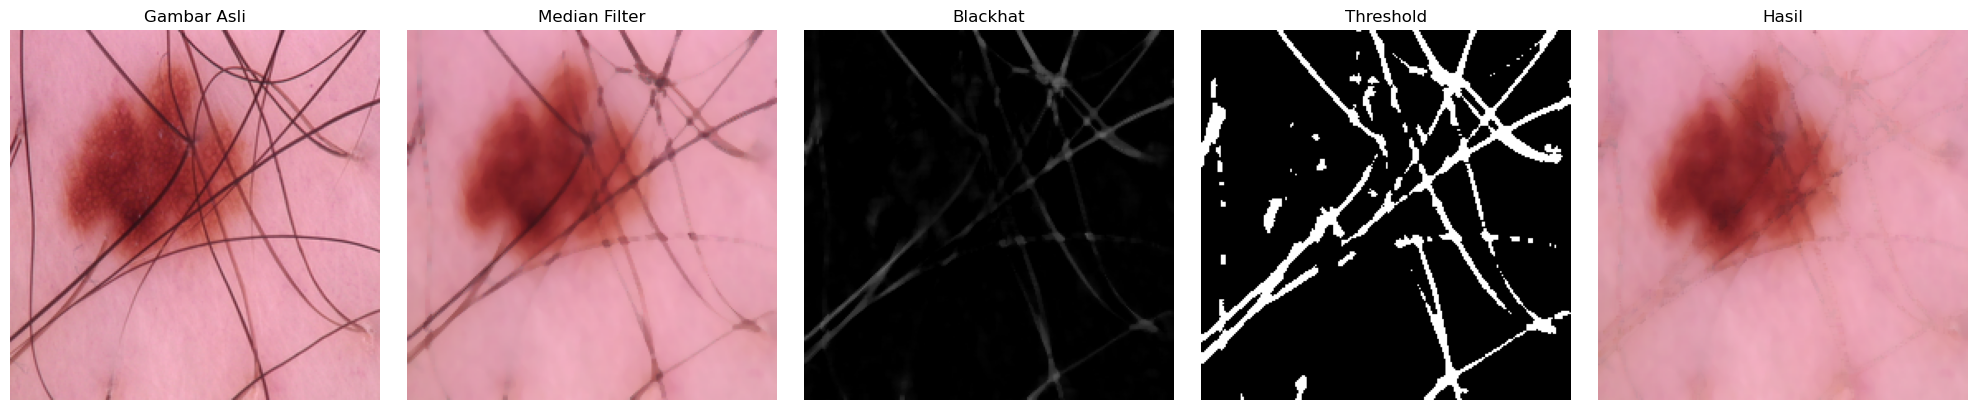

In [3]:
import cv2
from preprocessing import clean_image
%load_ext autoreload
%autoreload 2

# Read the input image
image_1 = cv2.imread('./data/raw/test/malignant/44.jpg')
image_2 = cv2.imread('./data/raw/test/benign/998.jpg')
image_3 = cv2.imread("./data/raw/test/benign/303.jpg")

image_1_removed_hair = clean_image(image_1, debug=True)
image_2_removed_hair = clean_image(image_2, debug=True)
image_3_removed_hair = clean_image(image_3, debug=True)


## Beberapa gambar yang berhasil di segmentasi


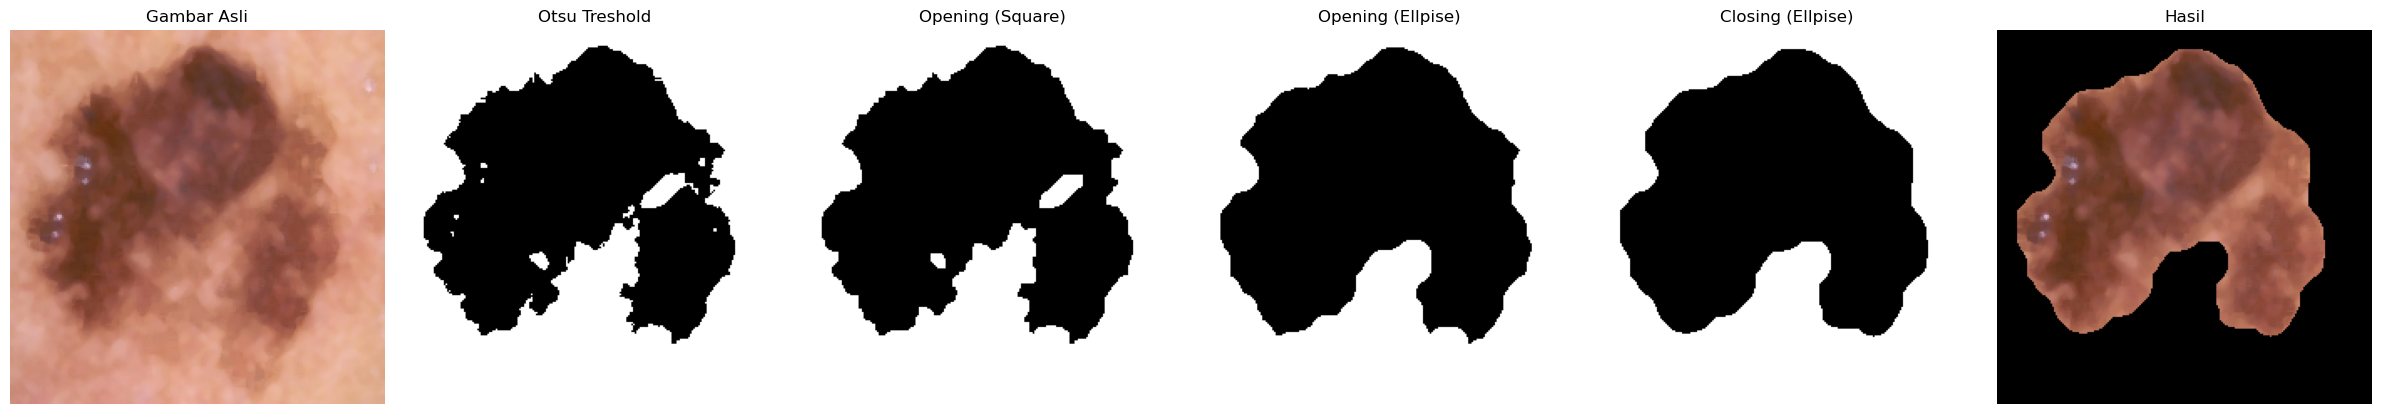

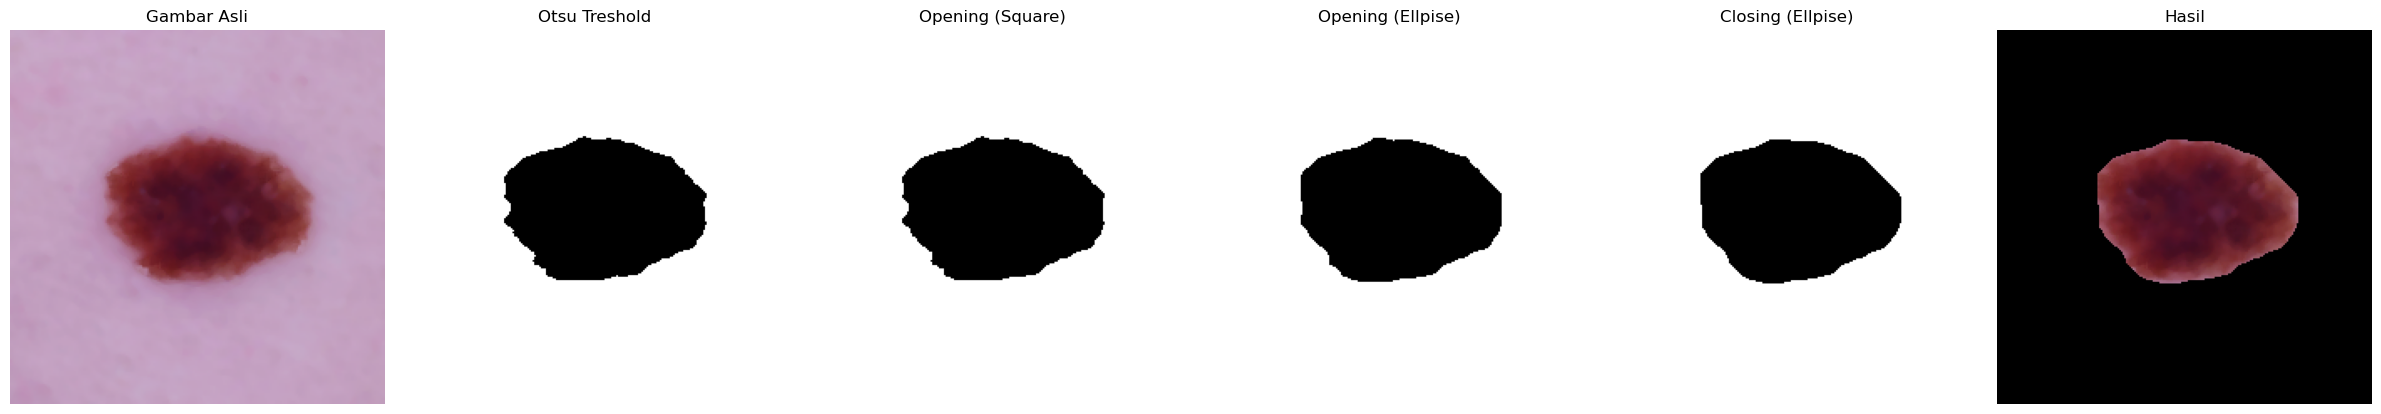

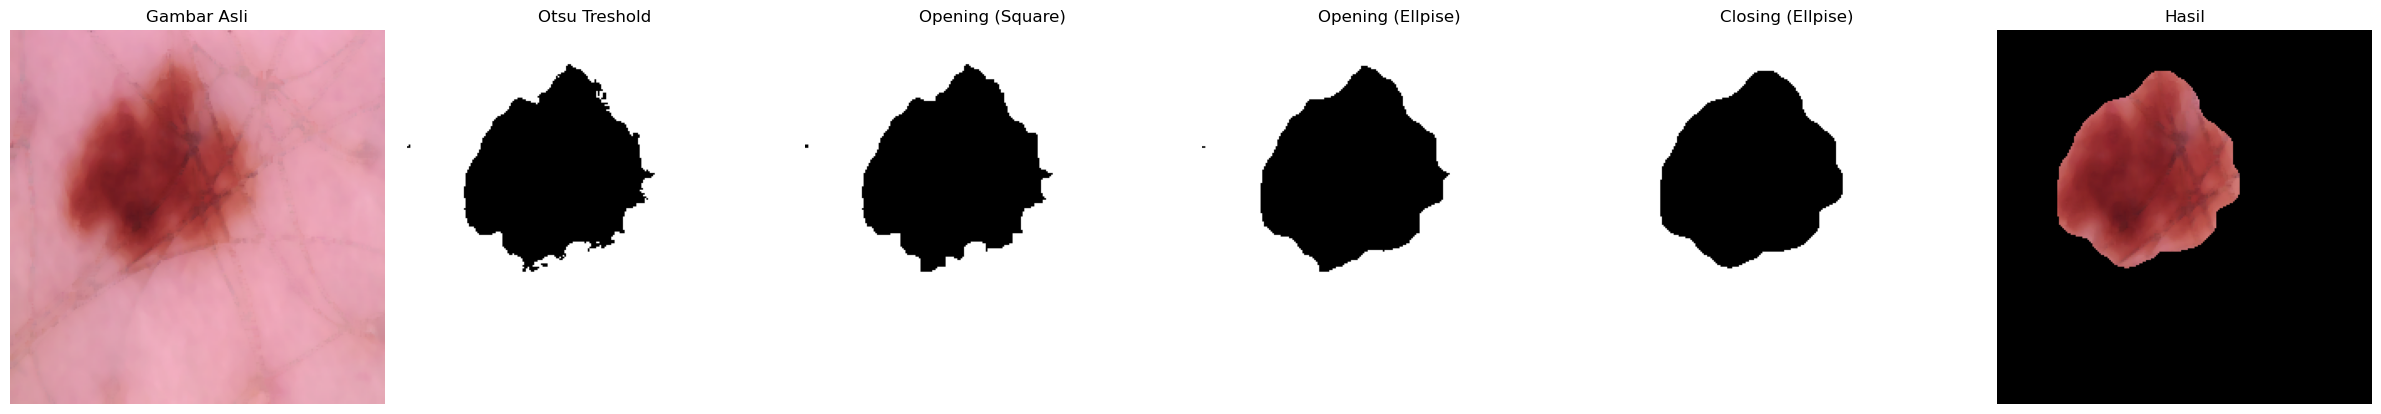

In [4]:
import cv2
import numpy as np
from preprocessing import preprocess_image

# Read the original image
image_1 = cv2.imread('./data/raw/train/malignant/975.jpg')
image_2 = cv2.imread('./data/raw/train/benign/804.jpg')
image_3 = cv2.imread("./data/raw/test/benign/303.jpg")


result_1 = preprocess_image(image_1, debug=True)
result_2 = preprocess_image(image_2, debug=True)
result_3 = preprocess_image(image_3, debug=True)

## Beberapa gambar yang gagal di segmentasi


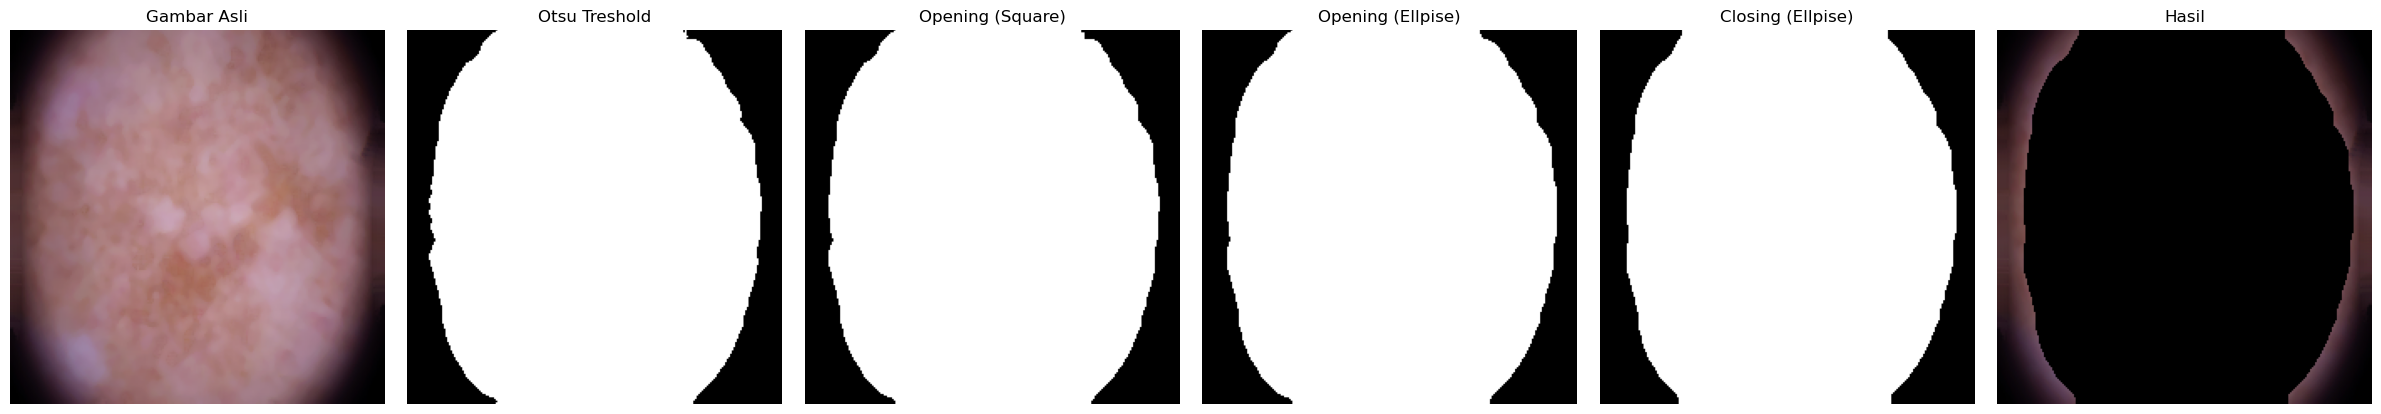

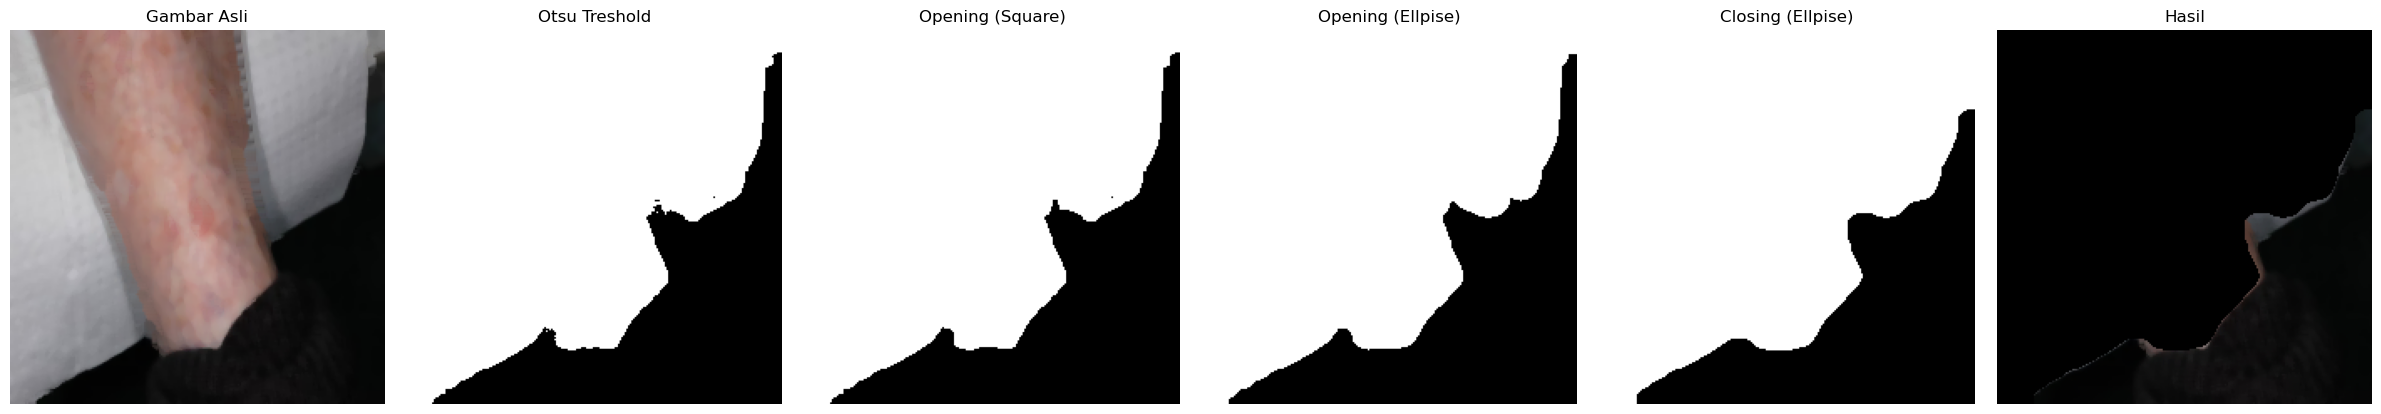

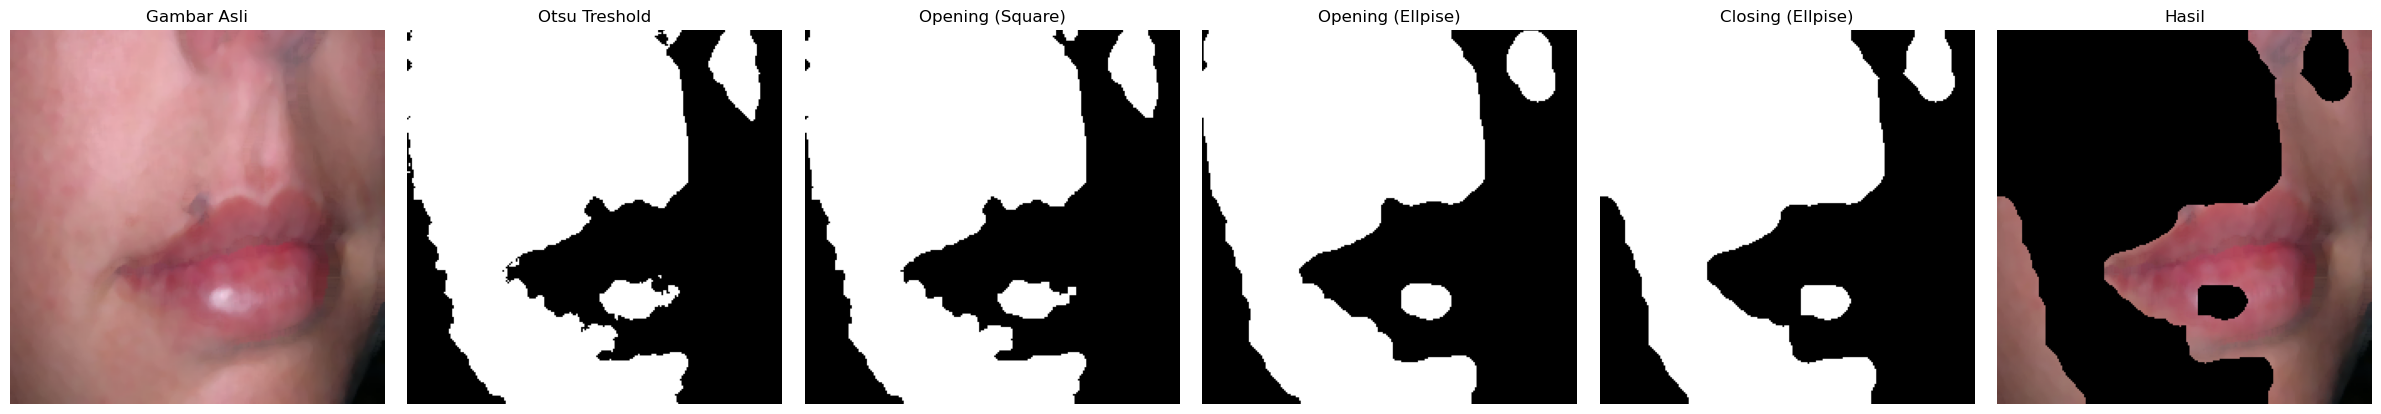

In [5]:
import cv2
from preprocessing import preprocess_image

image_1 = cv2.imread('./data/raw/train/malignant/840.jpg') # dikarenkan dermatoskop memiliki intensitas lebih gelap
image_2 = cv2.imread('./data/raw/train/malignant/768.jpg') # dikarenakan variasi data 
image_3 = cv2.imread('./data/raw/train/malignant/725.jpg') # dikarenakan variasi data

result_1 = preprocess_image(image_1, debug=True)
result_2 = preprocess_image(image_2, debug=True)
result_3 = preprocess_image(image_3, debug=True)


# Ekstraksi Fitur


In [6]:
# feature extraction
import cv2
import pandas as pd
from tqdm import tqdm

from featureextraction import calculate_hog_with_pca, get_file_path_with_label, calculate_texture_features, calculate_rgb_statistic, calculate_hsv_statistic, calculate_lab_statistic, calculate_shape_features
%load_ext autoreload
%autoreload 2

preprocessed_path = "data/preprocessed/"
train_features, test_features = get_file_path_with_label(preprocessed_path)

def extract_glcm_color_features(image_path: str) -> pd.Series:
    image = cv2.imread(image_path)
    
    features = []
    features.append(calculate_texture_features(image))
    features.append(calculate_shape_features(image))
    features.append(calculate_rgb_statistic(image))
    features.append(calculate_hsv_statistic(image))
    features.append(calculate_lab_statistic(image))
    
    combined_features = pd.concat(features, axis=0)
    return pd.Series(combined_features)

tqdm.pandas(desc="Extracting GLCM and Color Features On Test Set")
preprocessed_test = test_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

test_features = pd.concat(
    [
        test_features,
        preprocessed_test,
        calculate_hog_with_pca(test_features["image_path"])
    ],
    axis=1,
)

tqdm.pandas(desc="Extracting GLCM and Color Features On Train Set")
preprocessed_train = train_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

train_features = pd.concat(
    [
        train_features,
        preprocessed_train,
        calculate_hog_with_pca(train_features["image_path"])
    ],
    axis=1,
)

# save the features
train_features.to_csv("data/features/train_features.csv", index=False)
test_features.to_csv("data/features/test_features.csv", index=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Extracting HOG Features: 100%|██████████| 2637/2637 [00:57<00:00, 45.81image/s]


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib import pyplot as plt

train_df = pd.read_csv("data/features/train_features.csv")
test_df = pd.read_csv("data/features/test_features.csv")

# drop the image path
train_df.drop(columns=["image_path"], inplace=True)
test_df.drop(columns=["image_path"], inplace=True)

train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

display(train_df)
display(test_df)

,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,96.314421,0.842023,0.889208,0.925281,7347.0,8.756457,25.255090,637.819593,59.911705,...,-0.217815,-0.115371,-0.151804,-0.107962,-0.043725,-0.055378,-0.028857,0.281491,-0.018826,0.036684
1,0,69.949312,0.860061,0.904631,0.932363,6426.0,7.144770,22.617259,511.540425,49.083249,...,-0.054230,-0.029581,-0.036744,-0.479768,0.214301,-0.327325,0.069018,0.015354,-0.047867,0.052327
2,0,141.161339,0.616404,0.755495,0.959801,18138.0,27.598354,41.762076,1744.070963,60.282548,...,-0.093081,-0.083884,0.498064,0.107789,0.118768,0.282685,-0.009845,0.116832,0.218850,-0.293294
3,0,431.996791,0.517896,0.716687,0.953286,23023.0,52.629763,68.127782,4641.394713,128.736689,...,-0.176076,0.492966,-0.307228,0.803750,-0.157552,-0.099396,-0.071072,-0.336598,-0.024075,0.052886
4,0,274.711059,0.543754,0.718011,0.969052,21981.0,52.839605,66.535608,4426.987108,103.891216,...,-0.003382,-0.513335,-0.069248,0.406686,-0.227273,0.977035,-0.192342,-0.147224,0.429282,-0.039326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,1,492.650077,0.261729,0.534465,0.944636,35948.0,88.104193,66.615366,4437.607009,124.278516,...,-0.287083,-0.229620,0.287756,0.235291,-0.659515,-0.325424,0.550715,0.144715,0.437252,0.254595
2633,1,142.639526,0.821905,0.879331,0.920704,8205.0,10.189194,29.988210,899.292749,68.640261,...,0.255122,-0.533018,0.252289,0.259471,0.808682,-0.144880,-0.017171,0.141898,-0.292089,0.381633
2634,1,219.292770,0.494933,0.668431,0.945169,24082.0,34.901786,44.616517,1990.633610,65.035046,...,0.136463,-0.023708,-0.107711,-0.029657,-0.664577,-0.761408,0.158287,-0.738968,-0.558927,-0.037165
2635,1,209.759795,0.776790,0.851819,0.959443,10394.0,22.138772,50.608003,2561.169937,75.992801,...,0.155642,-0.356023,0.309671,0.065383,0.044084,-0.050195,-0.190212,-0.320521,0.298615,-0.031775


,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,96.629161,0.934126,0.954020,0.914090,2905.0,4.535794,23.578261,555.934385,81.158462,...,0.098011,-0.077325,-0.131834,-0.006043,-0.124625,0.080849,0.054297,0.065133,0.028749,-0.060417
1,0,329.943654,0.674323,0.780407,0.952885,15288.0,33.272600,58.966738,3477.076199,98.614666,...,0.072337,-0.063572,0.346998,0.128989,0.378729,-0.035327,0.366907,-0.190527,0.015179,0.102860
2,0,178.421753,0.537634,0.696717,0.956731,22196.0,35.179329,45.361323,2057.649601,58.287623,...,-0.168795,0.130405,0.232449,0.083548,0.155489,0.052320,0.936614,0.150779,-0.194277,0.299319
3,0,232.460309,0.586959,0.800749,0.982316,20149.0,61.146285,81.053432,6569.658806,152.056782,...,0.014350,0.018475,-0.017107,0.137564,0.313120,0.680767,-0.069240,0.229095,-0.409059,0.107274
4,0,254.746646,0.681246,0.812473,0.965921,15063.0,35.055106,60.938202,3713.464418,107.550653,...,-0.134912,-0.086545,-0.089927,-0.081425,0.108080,-0.238351,-0.280181,-0.216910,-0.137738,0.399128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,1,152.059232,0.648281,0.753001,0.949101,16703.0,23.798071,38.506704,1482.766224,71.980669,...,0.265840,-0.106194,-0.303052,-0.014454,0.146370,0.107480,0.100791,-0.419141,-0.145444,0.006995
656,1,180.487916,0.723639,0.817122,0.947928,12752.0,20.394133,41.441781,1717.421230,79.775316,...,0.533265,-0.139476,-0.540695,0.024598,-0.266917,0.217866,-0.695207,0.214083,0.110881,0.000810
657,1,428.677000,0.207945,0.420777,0.917765,38526.0,68.963170,51.256012,2627.178769,87.441192,...,-0.027637,-0.639132,-0.379955,-0.250434,0.521712,-0.057011,-0.204276,-0.423819,-0.303479,0.007116
658,1,174.866190,0.589609,0.716800,0.931852,19327.0,22.961655,35.694935,1274.128393,54.260602,...,-0.154476,-0.106430,-0.226643,0.465337,0.402661,-0.048874,-0.029283,-0.251165,0.285644,-0.076121


## Visualisasi Beberapa Fitur Channel Warna


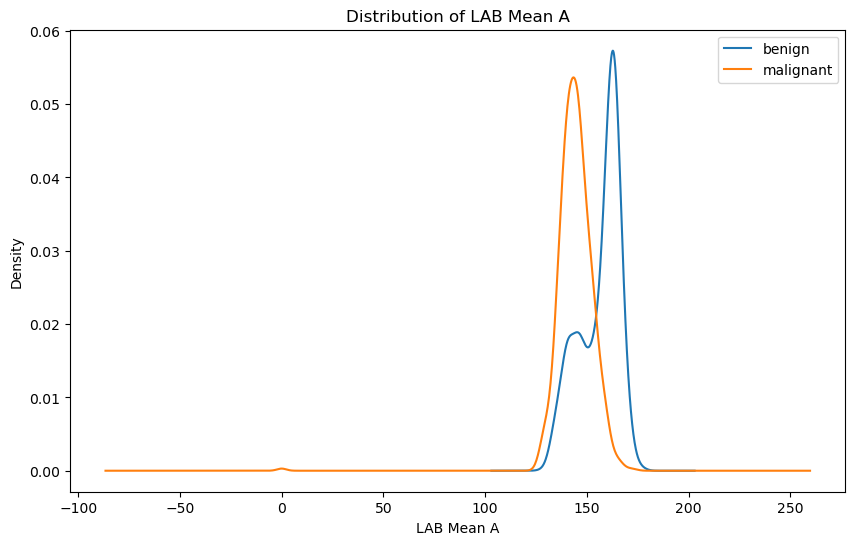

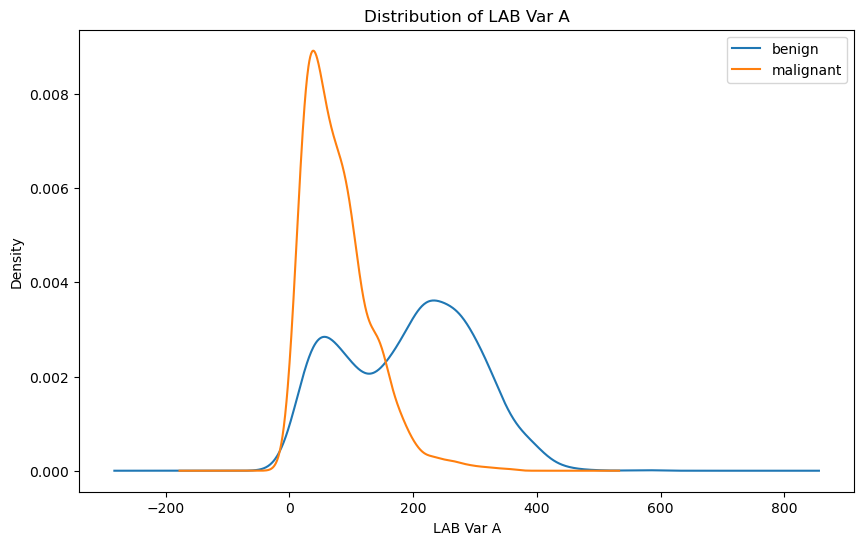

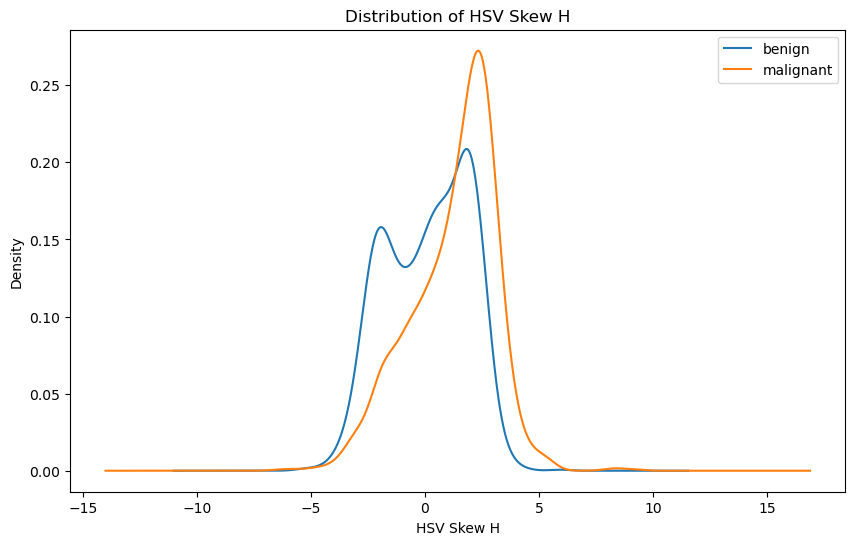

In [2]:
# visualize the label distribution on lab_mean_a between benign and malignant 
plt.figure(figsize=(10, 6))
plt.title("Distribution of LAB Mean A")
plt.xlabel("LAB Mean A")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["lab_mean_a"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["lab_mean_a"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Distribution of LAB Var A")
plt.xlabel("LAB Var A")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["lab_var_a"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["lab_var_a"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Distribution of HSV Skew H")
plt.xlabel("HSV Skew H")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["hsv_skew_h"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["hsv_skew_h"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()

## Visualisasi Beberapa Fitur HOG


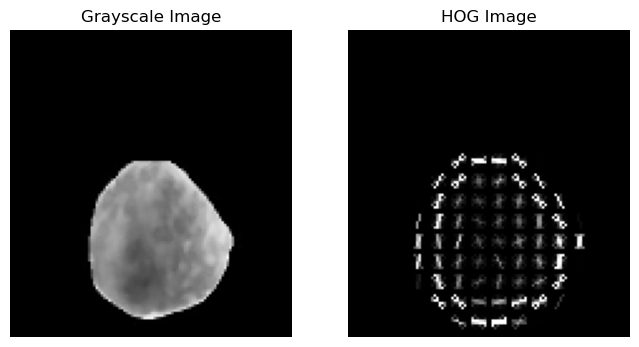

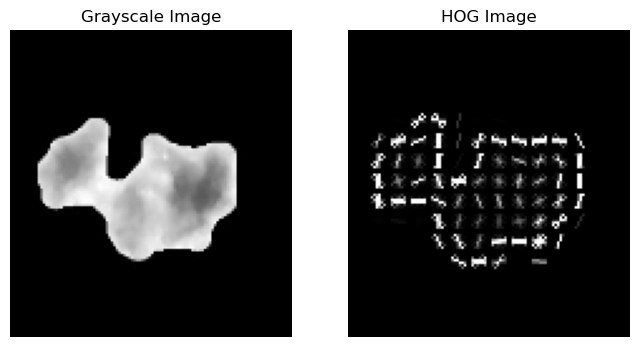

In [3]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

def visualize_hog(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, (112, 122))

    # Compute HOG features
    features, hog_image = hog(resized_image, orientations=8, pixels_per_cell=(8, 8),
                              cells_per_block=(1, 1), visualize=True)

    # Enhance the contrast of the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display the original image and HOG image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(resized_image, cmap=plt.cm.gray)
    ax1.set_title('Grayscale Image')

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('HOG Image')

    plt.show()

# Process benign image
visualize_hog("./data/preprocessed/test/benign/300.jpg")

# Process malignant image
visualize_hog("./data/preprocessed/test/malignant/985.jpg")


# Klasifikasi & Evaluasi


In [7]:
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd  # Make sure to import pandas if it's not imported

# Define X_train, y_train, X_test, y_test appropriately

lgbm = LGBMClassifier(  
    subsample=0.7,
    reg_lambda=0.01,
    reg_alpha=0.001,
    num_leaves=64,
    n_estimators=500,
    min_split_gain=0.025,
    min_child_weight=20,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.6,
    silent=-1,
    verbose=-1,
)

svm = SVC(kernel="linear", C=10, gamma=0.1, random_state=42, probability=True)

svm.fit(X_train, y_train)

lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# classification report for LightGBM
print("LightGBM")
y_pred_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)

y_pred_proba_lgbm = pd.DataFrame(y_pred_proba_lgbm)
y_pred_proba_lgbm.to_csv("data/lgbm_y_pred_proba.csv", index=False, float_format="%.5f")

print(classification_report(y_test, y_pred_lgbm))

# confusion matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt="d")
plt.title('Confusion Matrix - LightGBM')
plt.show()

# classification report for SVM
print("SVM")
y_pred_svm = svm.predict(X_test)
y_pred_proba_svm = svm.predict_proba(X_test)

y_pred_proba_svm = pd.DataFrame(y_pred_proba_svm)
y_pred_proba_svm.to_csv("data/svm_y_pred_proba.csv", index=False, float_format="%.5f")

print(classification_report(y_test, y_pred_svm))

# confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d")
plt.title('Confusion Matrix - SVM')
plt.show()
